In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_dir = '/content/drive/My Drive/Drexel/MEM679/chest_xray'

In [3]:
model_checkpoint = "google/vit-base-patch16-224-in21k" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [4]:
!pip install -q datasets transformers accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [7]:
from datasets import load_dataset

dataset = load_dataset('imagefolder', data_dir=data_dir,
                       split={'train': 'train', 'validation': 'validation', 'test': 'test'})

Resolving data files:   0%|          | 0/5216 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/624 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [8]:
from evaluate import load

metric = load("accuracy")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5216
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 16
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
})

In [10]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[1]

'PNEUMONIA'

In [11]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [12]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    RandomRotation,
    RandomAffine,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            RandomRotation(degrees=(-10, 10)), # Example: Rotate between -10 and 10 degrees
            RandomAffine(degrees=(-10, 10)), # Example: Rotate between -10 and 10 degrees
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [13]:
train_ds = dataset['train'].with_transform(preprocess_train)
val_ds = dataset['validation'].with_transform(preprocess_val)

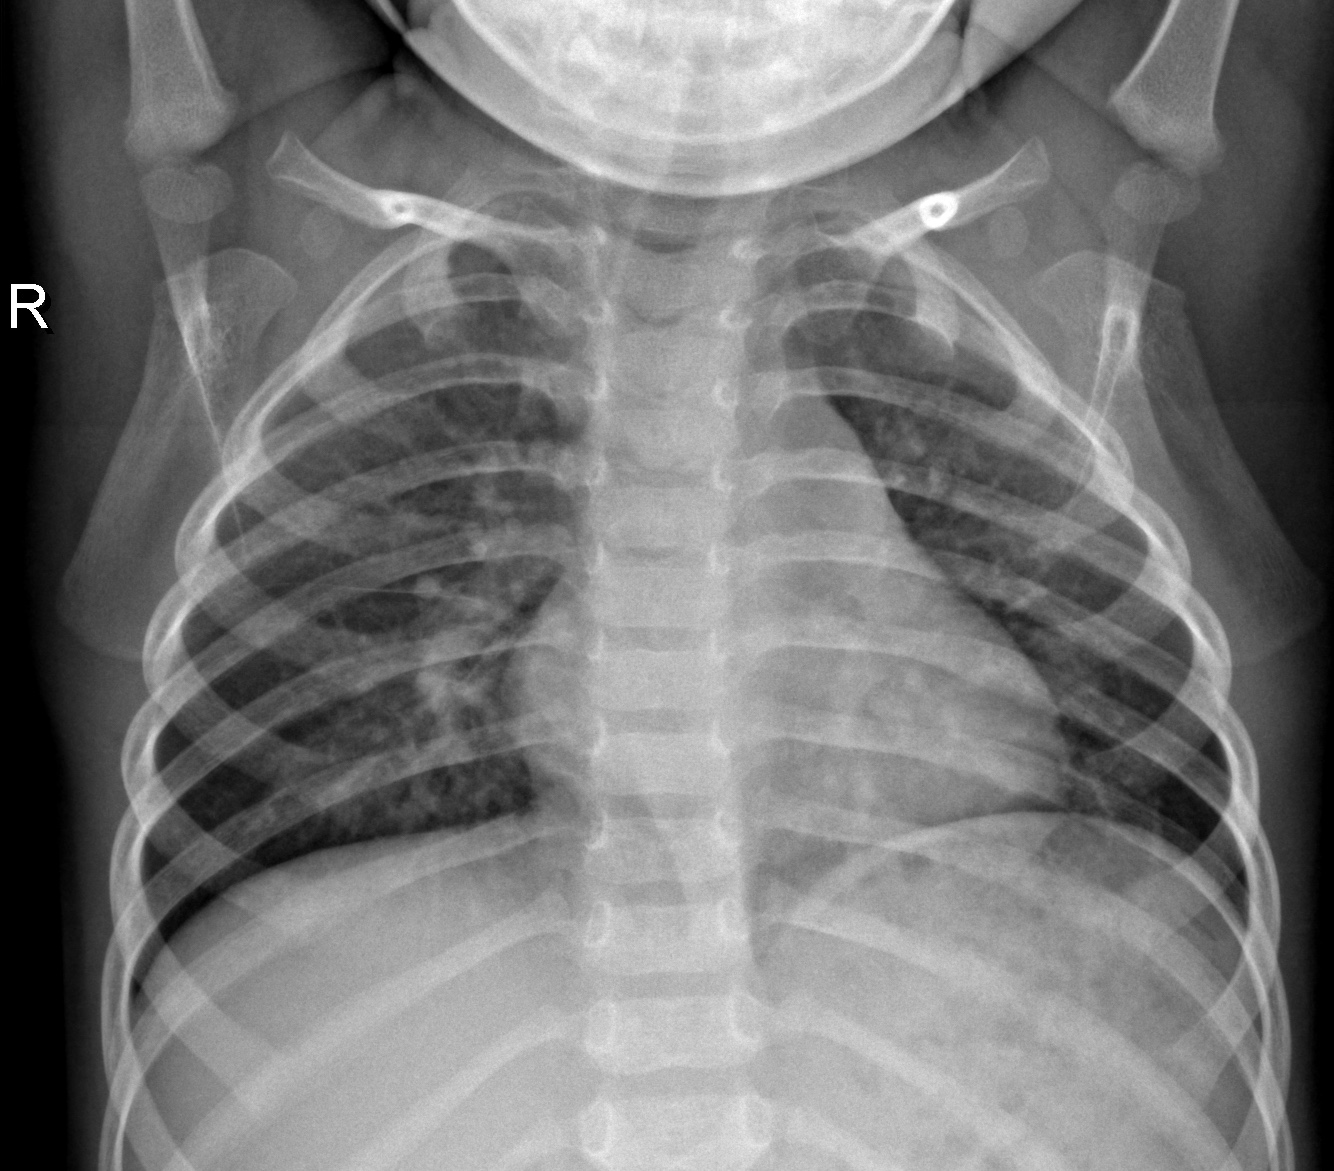

In [14]:
train_ds[1000]['image']

In [15]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True,
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    gradient_checkpointing=True,
    weight_decay=0.01,
    save_total_limit=2,
    lr_scheduler_type="cosine",
    push_to_hub=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [18]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [19]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=args.learning_rate)
num_training_steps = len(train_ds) // args.per_device_train_batch_size * args.num_train_epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * num_training_steps), num_training_steps=num_training_steps)

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    optimizers=(optimizer, lr_scheduler),
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-19-d25361647528>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
train_results = trainer.train()

trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
0,0.565100,0.702092,0.500000
1,0.300200,0.716198,0.625000
2,0.251000,0.825004,0.625000
4,0.176300,0.780307,0.625000
5,0.169400,0.391604,0.687500
6,0.157200,0.627469,0.812500
8,0.162900,0.579757,0.625000
9,0.167500,0.466154,0.812500
10,0.125400,0.448399,0.812500
12,0.130300,0.223478,0.875000


events.out.tfevents.1732583277.9493d3ea73e9.1094.0:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =      19.6319
  total_flos               = 7390212022GF
  train_loss               =       0.1779
  train_runtime            =   1:49:09.60
  train_samples_per_second =       15.928
  train_steps_per_second   =        0.122


In [21]:
metrics = trainer.evaluate()

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =    19.6319
  eval_accuracy           =        1.0
  eval_loss               =     0.1228
  eval_runtime            = 0:00:00.34
  eval_samples_per_second =      46.68
  eval_steps_per_second   =      2.918


In [22]:
trainer.push_to_hub()

events.out.tfevents.1732589875.9493d3ea73e9.1094.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Towen/vit-base-patch16-224-in21k-finetuned/commit/b46597c28b86b260545cab2323460022e74f21aa', commit_message='End of training', commit_description='', oid='b46597c28b86b260545cab2323460022e74f21aa', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Towen/vit-base-patch16-224-in21k-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='Towen/vit-base-patch16-224-in21k-finetuned'), pr_revision=None, pr_num=None)

In [24]:
total_samples = len(dataset['test'])
accuracy = 0

for i in dataset['test']:
    encoding = image_processor(i['image'].convert("RGB"), return_tensors="pt")

    # forward pass
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    predicted_class_idx = logits.argmax(-1).item()

    if predicted_class_idx == i['label']:
        accuracy += 1

print("Accuracy: ", accuracy/total_samples *100, "%")

Accuracy:  95.67307692307693 %


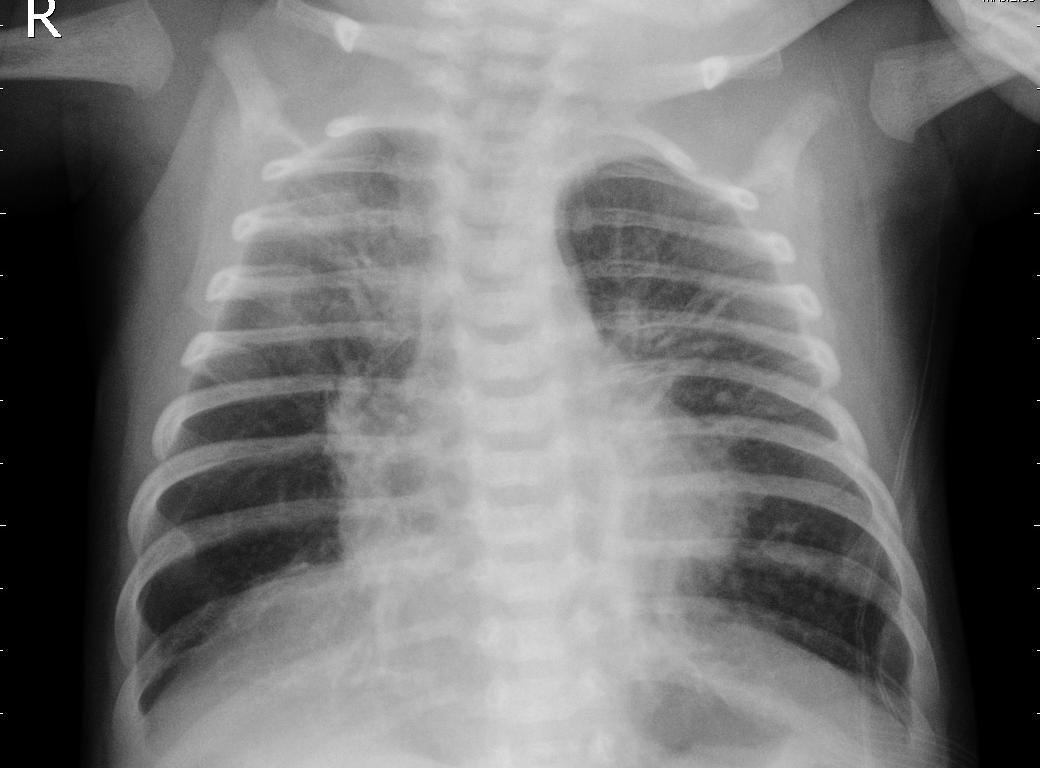

In [25]:
from PIL import Image

image = dataset['test'][520]

image['image']

In [26]:
# prepare image for the model
encoding = image_processor(image['image'].convert("RGB"), return_tensors="pt")
# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
label = "NORMAL"
if image['label'] == 1:
    label = "PNEUMONIA"

print("Predicted class:", model.config.id2label[predicted_class_idx])
print("Label class:", label)

Predicted class: PNEUMONIA
Label class: PNEUMONIA
